In [1]:
import csv

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

## Read entrez gene

In [2]:
# read entrez genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/genes-human.tsv'
entrez_df = pandas.read_table(url, dtype={'GeneID': str})
human_genes = set(entrez_df.GeneID)
human_coding_genes = set(entrez_df[entrez_df.type_of_gene == 'protein-coding'].GeneID)

## GMT functions

In [3]:
def read_gmt(path):
    read_file = open(path)
    reader = csv.reader(read_file, delimiter='\t')
    for row in reader:
        name = row[0]
        description = row[1]
        genes = set(row[2:])
        yield name, description, genes
    read_file.close()

## Resource downloads

In [4]:
%%capture

# download wikipathways
url = 'http://www.pathvisio.org/data/bots/gmt/wikipathways.gmt'
! wget --timestamping --directory-prefix=download $url

# download MSigDB 5.0 pathways
url = 'https://www.broadinstitute.org/gsea/resources/msigdb/5.0/c2.cp.v5.0.entrez.gmt'
! wget --timestamping --directory-prefix=download $url

## Parse WikiPathways

In [5]:
gmt_generator = read_gmt('download/wikipathways.gmt')
wikipath_df = pandas.DataFrame(gmt_generator, columns = ['name', 'description', 'genes'])
len(wikipath_df)

669

In [6]:
# Remove genes absent from our entrez gene version
for genes in wikipath_df.genes:
    genes &= human_genes
wikipath_df = wikipath_df[wikipath_df.genes.map(bool)]
len(wikipath_df)

187

In [7]:
wikipath_df.head()

,name,description,genes
92,Interleukin-11 Signaling Pathway(Homo sapiens),http://wikipathways.org/instance/WP2332,"set([6774, 1147, 3572, 6714, 3717, 5296, 3383,..."
93,NAD Biosynthesis II (from tryptophan)(Homo sap...,http://wikipathways.org/instance/WP2485,"set([64802, 23498, 8564, 23475, 55191, 6999, 1..."
94,AGE/RAGE pathway(Homo sapiens),http://wikipathways.org/instance/WP2324,"set([6774, 1147, 5590, 4088, 6714, 1432, 4481,..."
95,FSH signaling pathway(Homo sapiens),http://wikipathways.org/instance/WP2035,"set([1588, 6714, 1432, 5578, 5595, 374, 6446, ..."
96,Differentiation Pathway(Homo sapiens),http://wikipathways.org/instance/WP2848,"set([7422, 89780, 10468, 3082, 9241, 2323, 515..."


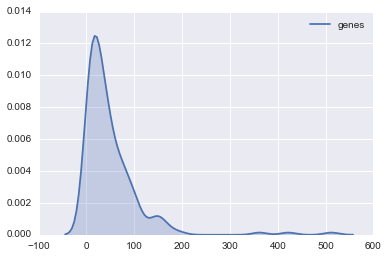

In [8]:
# Density plot of genes per pathway
seaborn.kdeplot(wikipath_df.genes.map(len), shade=True, );

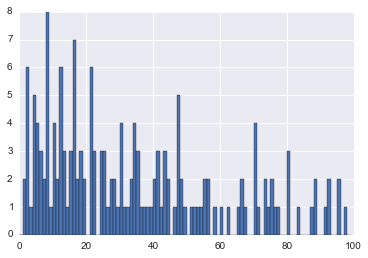

In [9]:
# Histogram of genes per pathway
plt.hist(list(wikipath_df.genes.map(len)), numpy.arange(100));
plt.xlim(0, 100);

## Parse MSigDB Pathways

In [10]:
gmt_generator = read_gmt('download/c2.cp.v5.0.entrez.gmt')
msigdb_df = pandas.DataFrame(gmt_generator, columns = ['name', 'description', 'genes'])
len(msigdb_df)

1330

In [11]:
# Remove genes absent from our entrez gene version
for genes in msigdb_df.genes:
    genes &= human_genes
msigdb_df = msigdb_df[msigdb_df.genes.map(bool)]
len(msigdb_df)

1330

In [12]:
msigdb_df.head()

,name,description,genes
0,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,http://www.broadinstitute.org/gsea/msigdb/card...,"set([2821, 5162, 2026, 130, 501, 126, 220, 523..."
1,KEGG_CITRATE_CYCLE_TCA_CYCLE,http://www.broadinstitute.org/gsea/msigdb/card...,"set([5162, 2271, 3419, 1431, 4967, 5161, 8803,..."
2,KEGG_PENTOSE_PHOSPHATE_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,"set([2821, 84076, 5634, 5236, 51071, 229, 7290..."
3,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,http://www.broadinstitute.org/gsea/msigdb/card...,"set([54657, 54490, 51181, 729020, 231, 10720, ..."
4,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,http://www.broadinstitute.org/gsea/msigdb/card...,"set([5209, 5372, 229, 29085, 3099, 231, 197258..."


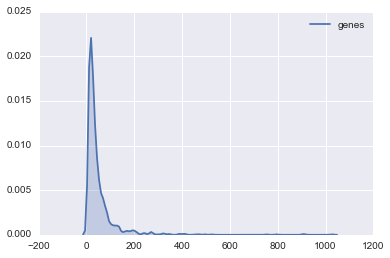

In [13]:
# Density plot of genes per pathway
seaborn.kdeplot(msigdb_df.genes.map(len), shade=True);

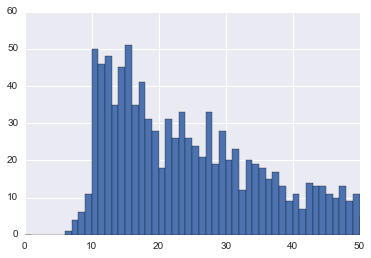

In [14]:
# Histogram of genes per pathway
plt.hist(msigdb_df.genes.map(len), numpy.arange(100));
plt.xlim(0, 50);

## Merge resources into a pathway dataframe

In [21]:
pathway_df = pandas.concat([
    pandas.DataFrame({
        'identifier': msigdb_df['name'],
        'name': msigdb_df['name'],
        'url': msigdb_df['description'],
        'source': 'msigdb',
        'genes': msigdb_df.genes}),

    pandas.DataFrame({
        'identifier': wikipath_df['description'].map(lambda x: x.rsplit('/', 1)[1]),
        'name': wikipath_df['name'],
        'url': wikipath_df['description'],
        'source': 'wikipathways',
        'genes': wikipath_df.genes
    })
])[['identifier', 'name', 'url', 'source', 'genes']]
len(pathway_df)

1517

In [22]:
# Remove duplicate pathways
pathway_df.genes = pathway_df.genes.map(frozenset)
pathway_df = pathway_df.drop_duplicates(['genes'])
len(pathway_df)

1516

In [23]:
pathway_df['coding_genes'] = pathway_df.genes.map(lambda x: x & human_coding_genes)

In [24]:
pathway_df.insert(3, 'n_genes', pathway_df.genes.map(len))
pathway_df.insert(4, 'n_coding_genes', pathway_df.coding_genes.map(len)) 

In [25]:
pathway_df.head()

,identifier,name,url,n_genes,n_coding_genes,source,genes,coding_genes
0,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,http://www.broadinstitute.org/gsea/msigdb/card...,62,62,msigdb,"(2821, 5162, 2026, 130, 501, 126, 220, 5236, 2...","(2821, 5162, 2026, 130, 126, 501, 220, 5236, 2..."
1,KEGG_CITRATE_CYCLE_TCA_CYCLE,KEGG_CITRATE_CYCLE_TCA_CYCLE,http://www.broadinstitute.org/gsea/msigdb/card...,32,30,msigdb,"(5162, 2271, 3419, 1431, 4967, 5161, 8803, 639...","(5162, 2271, 3419, 1431, 4967, 5161, 8803, 639..."
2,KEGG_PENTOSE_PHOSPHATE_PATHWAY,KEGG_PENTOSE_PHOSPHATE_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,27,27,msigdb,"(2821, 22934, 8789, 84076, 5634, 5236, 226, 51...","(2821, 84076, 5634, 5236, 51071, 229, 729020, ..."
3,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,http://www.broadinstitute.org/gsea/msigdb/card...,28,28,msigdb,"(54576, 7360, 7366, 54578, 54657, 51084, 54490...","(54657, 54490, 51181, 729020, 231, 10720, 5457..."
4,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,http://www.broadinstitute.org/gsea/msigdb/card...,34,34,msigdb,"(5209, 5372, 229, 29085, 3099, 231, 197258, 71...","(5209, 5372, 229, 29085, 3099, 231, 197258, 71..."


In [26]:
# Create a dataframe for writing as a tsv. Multi-element fields are pipe delimited.
write_df = pathway_df.copy()
join = lambda x: '|'.join(map(str, x))
for column in 'genes', 'coding_genes':
    write_df[column] = write_df[column].map(join)

write_df.to_csv('data/pathways.tsv', index=False, sep='\t')